In [4]:
# Importing libraries

# This code is strictly based on https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
# Check it out it is good article

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from contraction import CONTRACTION_MAP
import re
import nltk
%matplotlib inline

# Getting requests from site and save it into csv

In [5]:

urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

news_data = []
for url in urls:
    news_category = url.split('/')[-1]
    data = requests.get(url)
    soup = BeautifulSoup(data.content, 'html.parser')
        
    news_articles = [{'news_headline': headline.find('span', 
                                                        attrs={"itemprop": "headline"}).string,
                      'news_article': article.find('div', 
                                                      attrs={"itemprop": "articleBody"}).string,
                       'news_category': news_category}
                        
    for headline, article in zip(soup.find_all('div', class_=["news-card-title news-right-box"]),
                                 soup.find_all('div',class_=["news-card-content news-right-box"]))
                        ]
    news_data.extend(news_articles)
    

In [6]:
# Creating a dataframe
df =  pd.DataFrame(news_data)
df = df[['news_headline', 'news_article', 'news_category']]

In [7]:
df.head()

,news_headline,news_article,news_category
0,Man tries to track 2 packets of snacks bought ...,A 40-year-old businessman who didn't receive t...,technology
1,"I'm selling almost all physical possessions, w...",Billionaire Tesla CEO Elon Musk has claimed he...,technology
2,Mask-wearing robots greet COVID-19 patients in...,Hotels in Japan's Tokyo that have started hous...,technology
3,Blood of 'COVID-19 survivors' being sold as va...,Criminals are selling fake vaccines claiming t...,technology
4,We may not make money this year but won't fire...,American software company SAS Institute's bill...,technology


In [8]:
# Saving dataframe to csv

df.to_csv("data.csv",index =None)

In [9]:
# Dataa cleaning funstions

def remove_htmltags(text):                # Remove HTML tags
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):             # Normalizing accented charaters like ü
    import unicodedata
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP): # Expanding short words iike I've --> I have
    from contraction import CONTRACTION_MAP
    import contraction
    import re
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):              # Remove special characters
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def simple_stemmer(text):                                            # Stemming the words
    import nltk
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def simple_lemmatize(text):                                          # lammetizing the words
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer() 
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

def remove_stopwords(text, is_lower_case=False):                    # Remove stopwords
    from nltk.corpus import stopwords
    from nltk.tokenize import WordPunctTokenizer
    tokenizer = WordPunctTokenizer()
    stopword_list =stopwords.words('english')
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def noramalize_text(document,htmltags = True, accented_chars = True, contractions_exp = True,
                   text_lower_case = True,special_characters = True, stemmer_text = True, 
                   lemmatize_text = True, stopwords_remove = True):
    
    normalized_doc = []
    
    for text in document:
        if htmltags:
            text = remove_htmltags(text)
        
        if accented_chars:
            text = remove_accented_chars(text)
        
        if contractions_exp:
            text = expand_contractions(text)
        
        if text_lower_case:
            text = text.lower()
        # remove extra line
        text = re.sub(r'[\r|\n|\r\n]+', ' ',text)
        
        if special_characters:
            text = remove_special_characters(text)
            
        if stemmer_text:
            text = simple_stemmer(text)
        
        if lemmatize_text:
            text = simple_lemmatize(text)
        
        # remove extra whitespace
        text = re.sub(' +', ' ', text)   
        
        if stopwords_remove:
            text = remove_stopwords(text)
            
        normalized_doc.append(text)    
        
    return normalized_doc

In [10]:
# combining headline and article text for preprocessing it at the same time

df['full_text'] = df["news_headline"] + '. ' + df["news_article"]

In [11]:
df.head()

,news_headline,news_article,news_category,full_text
0,Man tries to track 2 packets of snacks bought ...,A 40-year-old businessman who didn't receive t...,technology,Man tries to track 2 packets of snacks bought ...
1,"I'm selling almost all physical possessions, w...",Billionaire Tesla CEO Elon Musk has claimed he...,technology,"I'm selling almost all physical possessions, w..."
2,Mask-wearing robots greet COVID-19 patients in...,Hotels in Japan's Tokyo that have started hous...,technology,Mask-wearing robots greet COVID-19 patients in...
3,Blood of 'COVID-19 survivors' being sold as va...,Criminals are selling fake vaccines claiming t...,technology,Blood of 'COVID-19 survivors' being sold as va...
4,We may not make money this year but won't fire...,American software company SAS Institute's bill...,technology,We may not make money this year but won't fire...


In [12]:
df["full_text"][0]

"Man tries to track 2 packets of snacks bought online for ₹400, loses over ₹2L. A 40-year-old businessman who didn't receive two bhujiya packets worth ₹400 ordered online, tried to search for a helpline number but landed on a fake number uploaded by a cyber fraudster. He ended up losing over ₹2 lakh after sharing bank details, UPI pin and OTP with the fraudster, Borivali Police said. An FIR was registered on Saturday."

In [13]:
# pre-process text and store the same
# noramalize_text(document,htmltags = True, accented_chars = True, contractions_exp = True,
#                   text_lower_case = True,special_characters = True, stemmer_text = True, 
#                   lemmatize_text = True, stopwords_remove = True):

df['clean_text'] = noramalize_text(df['full_text'],stemmer_text = False)
norm_corpus = list(df['clean_text'])

In [14]:
norm_corpus[0]

'man try track 2 packet snack bought online 400 loses 2l 40yearold businessman receive two bhujiya packet worth 400 ordered online tried search helpline number landed fake number uploaded cyber fraudster ended losing 2 lakh sharing bank detail upi pin otp fraudster borivali police said fir wa registered saturday'

In [15]:
# Saving the processed data for reuse

df.to_csv("Processed_doc.csv", index = None)

In [16]:
data = pd.read_csv("Processed_doc.csv")

In [17]:
data.head()

,news_headline,news_article,news_category,full_text,clean_text
0,Man tries to track 2 packets of snacks bought ...,A 40-year-old businessman who didn't receive t...,technology,Man tries to track 2 packets of snacks bought ...,man try track 2 packet snack bought online 400...
1,"I'm selling almost all physical possessions, w...",Billionaire Tesla CEO Elon Musk has claimed he...,technology,"I'm selling almost all physical possessions, w...",selling almost physical possession house billi...
2,Mask-wearing robots greet COVID-19 patients in...,Hotels in Japan's Tokyo that have started hous...,technology,Mask-wearing robots greet COVID-19 patients in...,maskwearing robot greet covid19 patient japan ...
3,Blood of 'COVID-19 survivors' being sold as va...,Criminals are selling fake vaccines claiming t...,technology,Blood of 'COVID-19 survivors' being sold as va...,blood covid19 survivor sold vaccine darknet re...
4,We may not make money this year but won't fire...,American software company SAS Institute's bill...,technology,We may not make money this year but won't fire...,may make money year fire anyone u software fir...


In [18]:
sentence = df.news_headline.iloc[1]

In [19]:
sentence

"I'm selling almost all physical possessions, won't own a house: Billionaire Musk"

# POS tagging with nltk

In [20]:
# POS tagging with nltk
import nltk

def pos_tagging(sentence):
    nltk_pos_tagged = nltk.pos_tag(sentence.split())
    pos_data = pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])
    return pos_data

In [21]:
data_pos = pos_tagging(sentence)
data_pos

,Word,POS tag
0,I'm,NNP
1,selling,VBG
2,almost,RB
3,all,DT
4,physical,JJ
5,"possessions,",NN
6,won't,NN
7,own,VB
8,a,DT
9,house:,NN


# Creating the shallow parser using nltk


In [22]:
# Creating the shallow parser using nltk
split = 10900

def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

def shallow_parser_trainer(data):
    train_data = data[:split]
    test_data = data[split:] 
    print("Length of train and test data --> \n")
    print(len(train_data), len(test_data))
    print(train_data[1]) 
    wtc = tree2conlltags(train_data[1])
    wtc
    # Training the parser
    from nltk.tag import UnigramTagger, BigramTagger
    from nltk.chunk import ChunkParserI

    # define the chunker class
    class NGramTagChunker(ChunkParserI):

        def __init__(self, train_sentences,tagger_classes=[UnigramTagger, BigramTagger]):
            train_sent_tags = conll_tag_chunks(train_sentences)
            self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

        def parse(self, tagged_sentence):
            if not tagged_sentence: 
                return None
            pos_tags = [tag for word, tag in tagged_sentence]
            chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
            chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
            wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                         in zip(tagged_sentence, chunk_tags)]
            return conlltags2tree(wpc_tags)


     # train chunker model  
    ntc = NGramTagChunker(train_data)

    # evaluate chunker model performance
    print(ntc.evaluate(test_data))

    train_data
    
    return ntc

In [23]:
from nltk.corpus import conll2000
from nltk.chunk.util import tree2conlltags, conlltags2tree
nltk.download('conll2000')
data = conll2000.chunked_sents()

clf = shallow_parser_trainer(data)

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\boltuzamaki\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
Length of train and test data --> 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)
ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [24]:
# Checking the parser
sentence = df.news_headline.iloc[1]          # Getting sentence from headline of news
pos_tagger = nltk.pos_tag(sentence.split())  # Creating position tagger 

chunk_tree = clf.parse(pos_tagger)
print(chunk_tree)

(S
  (NP I'm/NNP selling/VBG)
  almost/RB
  (NP all/DT physical/JJ possessions,/NN won't/NN)
  (VP own/VB)
  (NP a/DT house:/NN Billionaire/NNP Musk/NNP))


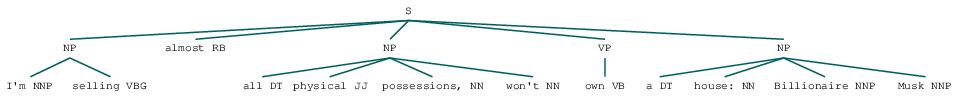

In [25]:
# Visual representation of shallow parser

from IPython.display import display

# First download ghostscript from https://www.ghostscript.com/download/gsdnld.html and install it 

# often need to add to the path manually (for windows)
os.environ['PATH'] = os.environ['PATH']+";C:\\Program Files\\gs\\gs9.52"

display(chunk_tree)

# Hand rule written parsing

In [26]:
# Chunking using manually assigned rules
import nltk

def hardcode_parsing(sentence, rule):
    nltk_pos_tagged = nltk.pos_tag(sent.split())
    print("POS tagged sentence -->\n", nltk_pos_tagged)
    grammer = rule
    parser = nltk.RegexpParser(grammer)
    output = parser.parse(nltk_pos_tagged)
    output.draw()

In [27]:
sent = "A beautiful young lady is walking on the pavement"
rule =  "NP: {<DT>?<JJ>*<NN>}"
hardcode_parsing(sent, rule)

POS tagged sentence -->
 [('A', 'DT'), ('beautiful', 'JJ'), ('young', 'JJ'), ('lady', 'NN'), ('is', 'VBZ'), ('walking', 'VBG'), ('on', 'IN'), ('the', 'DT'), ('pavement', 'NN')]


# Constituency Parsing

In [28]:
# First download official stanford paser from http://nlp.stanford.edu/software/stanford-parser-full-2015-04-20.zip
# Unzip it at any location we have to put that location in code


# set java path
import os
from IPython.display import display

java_loc = r'C:\Program Files\Java\jdk1.8.0_251\bin\java.exe'
path_jar_standford = "C:/Users/boltuzamaki/Desktop/NLP/parsers/stanford-parser-full-2015-04-20/stanford-parser.jar"

def stanford_constituency_parser(sentence):
    java_path = java_loc
    from nltk.parse.stanford import StanfordParser

    scp = StanfordParser(path_to_jar= path_jar_standford,
                         path_to_models_jar= path_jar_standford)

    result = list(scp.raw_parse(sentence))
    print(result[0])
    display(result[0])


C:\Users\boltuzamaki\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.StanforCoreNLPParser instead.


(ROOT
  (S
    (NP (DT A) (JJ beautiful) (JJ young) (NN lady))
    (VP
      (VBZ is)
      (VP (VBG walking) (PP (IN on) (NP (DT the) (NN pavement)))))))


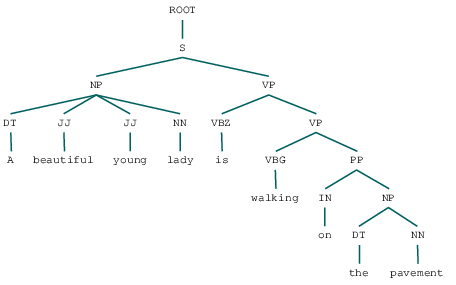

In [29]:
sentence = "A beautiful young lady is walking on the pavement"
stanford_constituency_parser(sentence)

# Dependency Parsing

In [36]:
import spacy
from spacy import displacy

depedency_pattern  = '{left}<---{word}[{w_type}]--->{right}\n--------'

def depedency_parsing(sentence):
    nlp = spacy.load('en_core_web_sm')
    sentence_nlp = nlp(sentence)
    dependency_pattern = depedency_pattern
    
    for token in sentence_nlp:
        print(dependency_pattern.format(word=token.orth_, 
                                      w_type=token.dep_,
                                      left=[t.orth_ 
                                                for t 
                                                in token.lefts],
                                      right=[t.orth_ 
                                                 for t 
                                                 in token.rights]))
        
        displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

In [35]:
sentence = str(df.iloc[1].news_headline)

In [37]:
depedency_parsing(sentence)

[]<---I[nsubj]--->[]
--------


[]<---'m[aux]--->[]
--------


['I', "'m"]<---selling[ROOT]--->['possessions', ',', 'own']
--------


[]<---almost[advmod]--->[]
--------


['almost']<---all[nummod]--->[]
--------


[]<---physical[amod]--->[]
--------


['all', 'physical']<---possessions[dobj]--->[]
--------


[]<---,[punct]--->[]
--------


[]<---wo[aux]--->[]
--------


[]<---n't[neg]--->[]
--------


['wo', "n't"]<---own[conj]--->['house', ':']
--------


[]<---a[det]--->[]
--------


['a']<---house[dobj]--->[]
--------


[]<---:[punct]--->[]
--------


[]<---Billionaire[compound]--->[]
--------


['Billionaire']<---Musk[ROOT]--->[]
--------
